In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import warnings 
warnings.filterwarnings("ignore")
pd.set_option("max.columns", 500)
pd.set_option("max.rows", 500)

Questions to explore: 
- Type of vaccine and number/percent of not serious side effects/serious side effects/deaths  
- How long until symptoms arise, separate between serious and non-serious symptoms
- Age distribution of serious and not-serious symptoms 
- Severity of symptoms with the number of active ingredients taking 
- Relate active ingredients in patient's medications and how they react to the vaccine 
- 

In [2]:
data = pd.read_csv("covid_vaccine_symptoms.csv")

In [4]:
df_stacked = data.groupby(["vax_manu", "serious_se"]).size().reset_index()
df_stacked["percentage"] = data.groupby(["vax_manu", "serious_se"]).size().groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).values
df_stacked.columns = ["Vaccine", "Side Effect", "Counts", "Percentage"]
df_stacked["text"] = df_stacked["Percentage"].apply(lambda x: round(x, 2)).astype(str) +  "% (" + df_stacked["Counts"].astype(str) + ")"
df_stacked["order"] = df_stacked["Side Effect"].apply(lambda x: 1 if x == "not serious" else
                                                                 2 if x == "serious" else
                                                                 3)
df_stacked = df_stacked.sort_values("order")
px.bar(df_stacked, x = "Vaccine", y = df_stacked["Percentage"].apply(lambda x: round(x, 2)), color = "Side Effect", text = df_stacked["text"], title = "% Serious Side Effect of Vaccine Distribution by Vaccine Type")

Unknown manufacturers has the highest rate of serious side effects however the number of doses administered is so small it is negligible. Of the main Covid-19 vaccines, J&J has both the lowest rate of serious side effects and the least amount of doses administered with 25,027 doses. Moderna has the most vaccines administered with 44,972 doses but has a lower rate of serious side effects compared to Pfizer. In order of vaccine releases, the later the vaccine was released, the lower the percentage of serious side effects. 

In [6]:
df_dens = data[data["numdays"] < 200].groupby([ "serious_se", "numdays"]).size().reset_index()
df_dens["percentage"] = data[data["numdays"] < 200].groupby(["serious_se", "numdays"]).size().groupby(level = 0).apply(lambda x: round(100 * x / float(x.sum()), 2)).values
#df_dens.columns = ["# Days", "Side Effect", "Count"]
px.line(df_dens[df_dens["numdays"] < 40], x = "numdays", y = "percentage", color = "serious_se", title = "Distribution of Serious Side Effects across # Days of Receiving Vaccine")

Most side effects are within 2 days of receiving the vaccine and the distribution of serious and non-serious side effects across days since receiving the vaccine is similar with almost half of the patients seeing side effects on the same day of receiving the vaccine and then sharply dipping in the following days. However, the distribution of patients who died is flatter curve, with a higher percentage in later days than that of the serious and not serious distributions, and most cases occur 1 day after receiving the vaccine. 

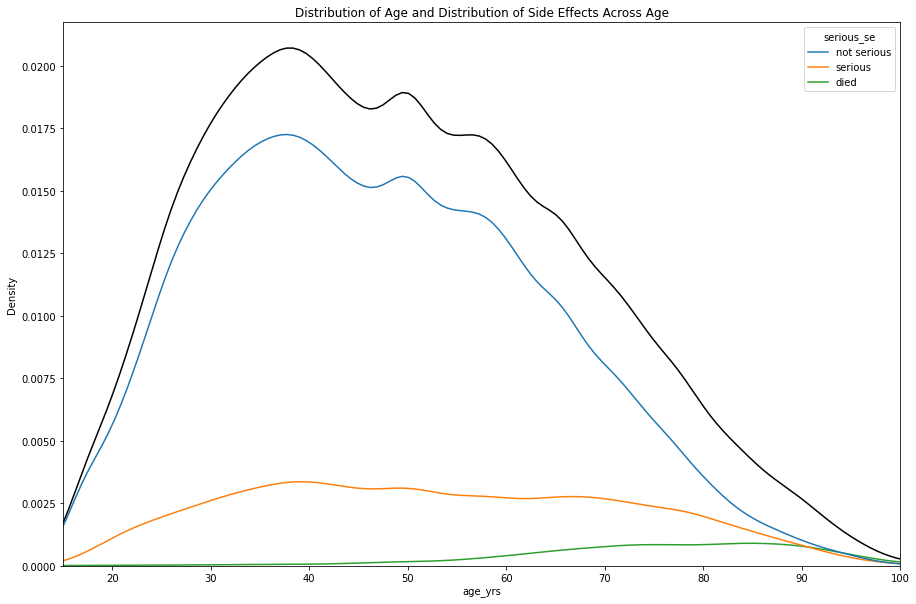

In [67]:
fig, axes = plt.subplots(figsize = (15, 10))
sns.kdeplot(data = data, x = "age_yrs", ax = axes, color = "black")
sns.kdeplot(data = data, x = "age_yrs", hue = "serious_se", ax = axes)
fig.subplots_adjust(hspace = 0.2)
axes.set_xlim(15, 100)
axes.set_title("Distribution of Age and Distribution of Side Effects Across Age")
plt.show()

Looking at the distribution of patients who had a side effect linked to a covid vaccine, most occurences happen right before the age of around 35 and then the occurrences gradually decrease with age. The not serious side effect distribution closely follows the trend of the general density. However the serious side effect distribution, instead of falling after around age 35, has a much flatter decrease compared to the general age distribution, most notably staying mostly stagnant between 40-50 instead of falling. The distribution of those who died remain flat until around the age of 55 and then begins to rise up to the age of 90.

In [10]:
# x1 = np.array(data[(data["serious_se"] == "not serious") & (data["numdays"] < 200)]["numdays"])
# x2 = np.array(data[(data["serious_se"] == "serious") & (data["numdays"] < 200)]["numdays"])
# x3 = np.array(data[(data["serious_se"] == "died") & (data["numdays"] < 200)]["numdays"])
# df_dens = [x1, x2, x3]
# group_labels = ["Not Serious", "Serious", "Died"]
# fig = ff.create_distplot(df_dens, group_labels, show_hist = False)
# fig.show()

In [12]:
# df_dens2 = data.copy()
# df_dens2["num_active_ing"] = df_dens2["active_ingredients"].apply(lambda x: len(eval(x)))
# df_dens2 = df_dens2[df_dens2["num_active_ing"] > 0]
# x1 = np.array(df_dens2[(df_dens2["serious_se"] == "not serious")]["num_active_ing"])
# x2 = np.array(df_dens2[(df_dens2["serious_se"] == "serious")]["num_active_ing"])
# x3 = np.array(df_dens2[(df_dens2["serious_se"] == "died")]["num_active_ing"])
# df_dens2 = [x1, x2, x3]
# group_labels = ["Not Serious", "Serious", "Died"]
# fig = ff.create_distplot(df_dens2, group_labels, show_hist = False)
# fig.show()

In [19]:
from scipy.stats import chi2_contingency 

In [77]:
#Are patients who have are taking medication more likely to experience serious side effects? 
df2 = data.copy()
df2["num_active_ing"] = df2["active_ingredients"].apply(lambda x: len(eval(x)))
df2["has_active_ing"] = df2["num_active_ing"] > 0
chisqt = pd.crosstab(df2["has_active_ing"], df2["serious_se"])
chisqt

serious_se,died,not serious,serious
has_active_ing,,,
False,2020,50842,10217
True,1365,34849,8364


In [88]:
chi2_contingency(chisqt.values)[1]

6.693571593291292e-27

In [82]:
df_stacked2 = df2.groupby(["has_active_ing", "serious_se"]).size().reset_index()
df_stacked2["percentage"] = df2.groupby(["has_active_ing", "serious_se"]).size().groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).values
df_stacked2.columns = ["Has Active Ingredient", "Side Effect", "Counts", "Percentage"]
df_stacked2["text"] = df_stacked2["Percentage"].apply(lambda x: round(x, 2)).astype(str) +  "% (" + df_stacked2["Counts"].astype(str) + ")"
df_stacked2["order"] = df_stacked2["Side Effect"].apply(lambda x: 1 if x == "not serious" else
                                                                 2 if x == "serious" else
                                                                 3)
df_stacked2 = df_stacked2.sort_values("order")
px.bar(df_stacked2, x = "Has Active Ingredient", y = df_stacked2["Percentage"].apply(lambda x: round(x, 2)), color = "Side Effect", text = df_stacked2["text"], title = "% Serious Side Effect of Vaccine Distribution by Active Ingredients in Patient's Medication")

In [100]:
df3 = df2.copy()
df3["num_active_ing"] = df3["num_active_ing"].apply(lambda x: "10+" if x >= 10 else str(x))
df_stacked3 = df3.groupby(["num_active_ing", "serious_se"]).size().reset_index()
df_stacked3["percentage"] = df3.groupby(["num_active_ing", "serious_se"]).size().groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).values
df_stacked3.columns = ["# Active Ingredients", "Side Effect", "Counts", "Percentage"]
df_stacked3["text"] = df_stacked3["Percentage"].apply(lambda x: round(x, 2)).astype(str) +  "% (" + df_stacked3["Counts"].astype(str) + ")"
df_stacked3["order"] = df_stacked3.apply(lambda x: 1 + int(x["# Active Ingredients"].split("+")[0]) if x["Side Effect"] == "not serious" else
                                                    2 + int(x["# Active Ingredients"].split("+")[0]) if x["Side Effect"] == "serious" else
                                                    3 + int(x["# Active Ingredients"].split("+")[0]), axis = 1)
df_stacked3 = df_stacked3.sort_values("order")
df_stacked3
px.bar(df_stacked3, x = "# Active Ingredients", y = df_stacked3["Percentage"].apply(lambda x: round(x, 2)), color = "Side Effect", text = df_stacked3["text"], title = "% Serious Side Effect of Vaccine Distribution by # Active Ingredients in Patient's Medication")

In [105]:
df2[["age_yrs", "num_active_ing"]].corr()

,age_yrs,num_active_ing
age_yrs,1.000000,0.198663
num_active_ing,0.198663,1.000000
